In [1]:
import tdt
import numpy as np
import matplotlib.pyplot as plt

import scipy.signal as sig

%run "..\\fx4assembly.py"
%run "..\\fx4behavior.py"
%run "..\\fx4makingsnips.py"

%matplotlib inline

In [2]:
test_sessions = metafile2sessions("..\\data\\test_ppp3.xlsx",
                                  "..\\data\\test",
                                  "..\\data\\",
                                  "..\\output\\")

In [3]:
ppp1_sessions = metafile2sessions('D:\\DA_and_Reward\\es334\PPP1\\PPP1.xlsx',
                                  'D:\\DA_and_Reward\\es334\PPP1\\PPP1_metafile',
                                  'D:\\DA_and_Reward\\es334\\PPP1\\tdtfiles\\',
                                  'D:\\DA_and_Reward\\es334\\PPP1\\output\\',
                                  sheetname='metafile')

In [4]:
ppp4_sessions = metafile2sessions('D:\\DA_and_Reward\\gc214\\PPP4\\PPP4.xlsx',
                                  'D:\\DA_and_Reward\\gc214\\PPP4\\PPP4_metafile',
                                  'D:\\DA_and_Reward\\gc214\\PPP4\\tdtfiles\\',
                                  'D:\\DA_and_Reward\\gc214\\PPP4\\output\\',
                                  sheetname='PPP4_metafile')

In [70]:
test_sessions
# s = test_sessions['PPP1-7_s10'] # for testing PPP1
# s = test_sessions['PPP3-6_s10'] # for testing PPP3
s = ppp4_sessions['PPP4-5_s10'] # for testing different rats in PPP4
s = ppp1_sessions['PPP1-7_s10'] # for testing different rats in PPP4

s.loaddata()
s.data_filt = correctforbaseline(s.data, s.dataUV)
s.setticks()
s.time2samples()
s.check4events()
s.setbottlecolors()

read from t=0s to t=2473.96s
read from t=0s to t=2473.96s
read from t=0s to t=2473.96s


In [71]:
try:
    s.left['lickdata'] = lickCalc(s.left['licks'],
                      offset = s.left['licks_off'],
                      burstThreshold = 0.50)
except IndexError:
    s.left['lickdata'] = 'none'
    print('No left licks')
    
try:
    s.right['lickdata'] = lickCalc(s.right['licks'],
              offset = s.right['licks_off'],
              burstThreshold = 0.50)
except IndexError:
    s.right['lickdata'] = 'none'
    print('No right licks')

In [72]:
bins = 300

s.randomevents = makerandomevents(120, max(s.tick)-120)
s.bgTrials, s.pps = snipper(s.data, s.randomevents,
                                t2sMap = s.t2sMap, fs = s.fs, bins=bins)

s.bgMAD = findnoise(s.data_filt, s.randomevents,
                              t2sMap=s.t2sMap, fs=s.fs, bins=bins,
                              method='sum')

In [73]:
for side in [s.left, s.right]:   
    if side['exist'] == True:
        side['snips_sipper'] = mastersnipper(s, side['sipper'], peak_between_time=[0, 5],
                                             latency_events=side['lickdata']['rStart'],
                                             latency_direction='post',
                                            threshold=8)
        side['snips_licks'] = mastersnipper(s, side['lickdata']['rStart'], peak_between_time=[0, 2],
                                            latency_events=side['sipper'],
                                            latency_direction='pre',
                                           threshold=8)
                                           
        try:
            forced_licks = [licks for licks in side['lickdata']['rStart'] if licks in side['licks-forced']]
            side['snips_licks_forced'] = mastersnipper(s, forced_licks, peak_between_time=[0, 2],
                                                       latency_events=side['sipper'],
                                                       latency_direction='pre',
                                                      threshold=10)
        except KeyError:
            pass
        try:
            side['lats'] = latencyCalc(side['lickdata']['licks'], side['sipper'], cueoff=side['sipper_off'], lag=0)
        except TypeError:
            print('Cannot work out latencies as there are lick and/or sipper values missing.')
            side['lats'] = []
s.side2subs()

21 events to analyze.
0 noise trials removed
37 events to analyze.
0 noise trials removed
21 events to analyze.
0 noise trials removed
21 events to analyze.
0 noise trials removed
29 events to analyze.
0 noise trials removed
22 events to analyze.
0 noise trials removed


In [74]:
s.cas['snips_licks_forced'].keys()

dict_keys(['blue', 'uv', 'filt', 'filt_z', 'filt_z_adjBL', 'filt_avg', 'filt_avg_z', 'noise', 'peak', 'latency'])

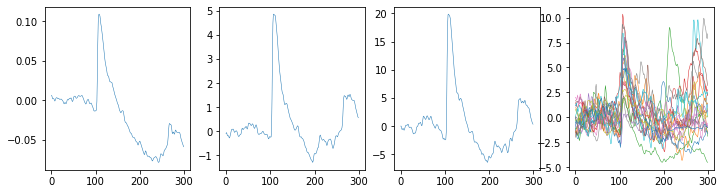

In [75]:
f, ax = plt.subplots(ncols=4, figsize=(12,3))
data = [snip for snip, noise in zip(s.cas['snips_sipper']['filt_z'], s.cas['snips_sipper']['noise']) if not noise]
ax[0].plot(np.mean(s.cas['snips_sipper']['blue'], axis=0))
ax[1].plot(np.mean(data, axis=0))
ax[2].plot(s.cas['snips_sipper']['filt_avg_z'])
for trial in data:
    ax[3].plot(trial)


In [76]:
from scipy import stats

cas = s.cas['snips_licks_forced']['peak']
malt = s.malt['snips_licks_forced']['peak']

result = stats.ttest_ind(cas, malt)
print(np.mean(cas), np.mean(malt))
print(result)



2.355709614975032 2.1893746519102133
Ttest_indResult(statistic=0.5885498629325618, pvalue=0.5593918727743568)


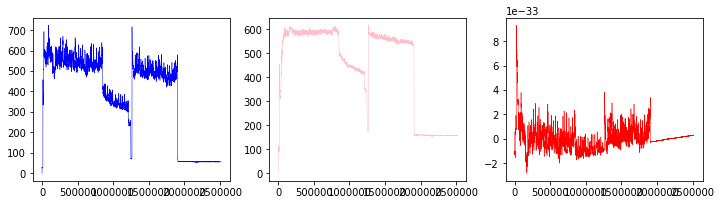

In [77]:
f, ax = plt.subplots(ncols=3, figsize=(12, 3))
ax[0].plot(s.data, color='blue')
ax[1].plot(s.dataUV, color='pink')
ax[2].plot(s.data_filt, color='red')



In [75]:
def rms(data):
    return np.sqrt(np.mean(np.square(data)))

print(rms(s.data_filt))

def rolling_rms(data, window=1000):
    output=[]
    start=0
    end=window
    while end < len(data):
        output.append(rms(data[start:end]))
        start = start+window
        end = end+window
    
    return output
        
    
out=rolling_rms(s.data_filt)

1.7487955184942376e-33


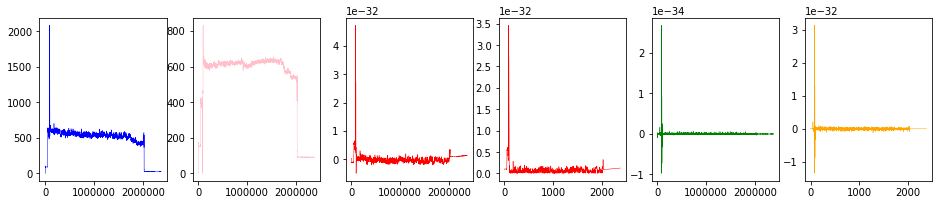

In [76]:
f, ax = plt.subplots(ncols=6, figsize=(16, 3))
ax[0].plot(s.data, color='blue')
ax[1].plot(s.dataUV, color='pink')
ax[2].plot(s.data_filt, color='red')
ax[3].plot(out, color='red')
ax[4].plot(np.diff(s.data_filt), color='green')
ax[5].plot(np.diff(out), color='orange')


In [117]:
# side=s.right
# side['snips_sipper'] = mastersnipper_filt(s, side['sipper'], peak_between_time=[0, 5])
# s.side2subs()

In [ ]:
# ax[0].plot(np.mean(s.cas['snips_sipper']['filt'], axis=0))
# ax[1].plot(np.mean(s.cas['snips_sipper']['filt_z'], axis=0))
# ax[2].plot(np.mean(s.cas['snips_sipper']['filt_z_adjBL'], axis=0))
# ax[3].plot(s.cas['snips_sipper']['filt_avg'])

    
for blue, uv, diff, filt, filt_z in zip(s.cas['snips_sipper']['blue'],
                                        s.cas['snips_sipper']['uv'],
                                        s.cas['snips_sipper']['diff'],
                                        s.cas['snips_sipper']['filt'],
                                        s.cas['snips_sipper']['filt_z']):
    f, ax = plt.subplots(ncols=4, figsize=(12,4))
    ax[0].plot(blue)
    ax[0].plot(uv)
    ax[1].plot(diff)
    ax[2].plot(filt)
    ax[3].plot(filt_z)

In [ ]:
s.cas['snips_sipper']['blue']

In [ ]:
s.cas['snips_licks_forced'].keys()

In [ ]:
s.ttls

In [ ]:
# how do we work out if there are n consecutive values that exceed a certain threshold (z_thresh) in a certain time window (e.g. 0-5 s after event)?
for filt_z in s.cas['snips_sipper']['filt_z']:
#     f, ax = plt.subplots()
#     ax.plot(filt_z)
    thresh = 2.5
    signifarray = [1 if val > thresh else 0 for val in filt_z[100:151]]
    
    
print(signifarray)

In [ ]:
diff = np.diff(signifarray)
diff.index(-1)

In [ ]:
np?

In [69]:
def findsigtrials(snips, sigbins=3, threshold=1.64):
    print(len(snips))
    
    sigvals_consecutive=[]
    for snip in snips:
        sigvals = [1 if t>threshold else 0 for t in snip[100:150]]
        sigvals.insert(0,0) # adds 0 at beginning to make looking for first increase reliable
        sigvals.insert(51,0) # adds 0 at beginning to make looking for first increase reliable
        # print(sigvals)
        #sigvals_consecutive.append(max(map(len, sigvals.split('0'))))
        d = np.diff(sigvals)
        
        ups = np.where(d==1)
        downs = np.where(d==-1)
        
        cons=[]
        for u, d in zip(ups, downs):
            cons.append(d-u)
        try:
            sigvals_consecutive.append(np.max(cons))
        except ValueError:
            sigvals_consecutive.append(0)

    print(sigvals_consecutive)
    
    return [True if trial > sigbins else False for trial in sigvals_consecutive]

    
sigtrials = findsigtrials(s.cas['snips_sipper']['filt_z'])

print(sigtrials)

22
[5, 4, 32, 0, 7, 0, 39, 22, 49, 0, 25, 15, 24, 50, 3, 0, 42, 3, 45, 42, 24, 50]
[True, True, True, False, True, False, True, True, True, False, True, True, True, True, False, False, True, False, True, True, True, True]
